# Loan Approval Prediction

<img src="https://quickzy.com.au/wp-content/uploads/2024/07/loan-rejection-loan-approved-Quickzy-Finance.png" />

This is a KAGGLE competition "Playground Series - Season 4, Episode 10". The goal for this competition is to predict whether an applicant is approved for a loan.

Submissions are evaluated using area under the ROC curve using the predicted probabilities and the ground truth targets.

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
from sklearn.metrics import roc_curve

import optuna
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix, matthews_corrcoef, roc_auc_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from lightgbm import log_evaluation, early_stopping, LGBMClassifier, Dataset
from sklearn.utils.class_weight import compute_class_weight
from catboost import CatBoostClassifier

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

## Reading the data

In [2]:
# Locating the file
file = zipfile.ZipFile('../Data/playground-series-s4e10.zip')

# Looking for file names
for i in file.filelist:
    print(i.filename)

sample_submission.csv
test.csv
train.csv


In [3]:
# Reading the train and test data

with file.open('train.csv') as train:
    df_train = pd.read_csv(train)
    
with file.open('test.csv') as test:
    df_test = pd.read_csv(test)
    
df_train.shape, df_test.shape

((58645, 13), (39098, 12))

In [4]:
with file.open('sample_submission.csv') as sample:
    df_sample = pd.read_csv(sample)
    
df_sample.shape

(39098, 2)

In [5]:
# Locating the original file
file_original = zipfile.ZipFile('../Data/original.zip')

# Looking for file names
for i in file_original.filelist:
    print(i.filename)

credit_risk_dataset.csv


In [6]:
# Reading the original data

with file_original.open('credit_risk_dataset.csv') as original:
    df_original = pd.read_csv(original)
    
df_original.shape

(32581, 12)

## Data Wrangling

In [57]:
# Combining the Train and Test dataframes for operation

df_total = pd.concat([df_train, df_test], axis=0)

In [58]:
# Adding Original dataset to the df_total

df_total_origin = pd.concat([df_total, df_original], axis=0)

### Checking the missing values

In [59]:
df_total_origin.isnull().sum()

id                            32581
person_age                        0
person_income                     0
person_home_ownership             0
person_emp_length               895
loan_intent                       0
loan_grade                        0
loan_amnt                         0
loan_int_rate                  3116
loan_percent_income               0
cb_person_default_on_file         0
cb_person_cred_hist_length        0
loan_status                   39098
dtype: int64

In [60]:
# Filling null values

mean_emp_length = float(round(df_total_origin['person_emp_length'].mean()))
mean_int_rate = round(df_total_origin['loan_int_rate'].mean(),2)

# Filling null values with the mean and rounding for person_emp_length
df_total_origin['loan_int_rate'] = df_total_origin['loan_int_rate'].fillna(mean_int_rate)
df_total_origin['person_emp_length'] = df_total_origin['person_emp_length'].fillna(mean_emp_length)

We have null values only for the 'loan_status' of the test set, because we have to predict them.<br>
The null values in 'id' column are from original df.<br>
There are no null values in the other features of the dataframe

### Cleaning the data

In [61]:
df_total_origin.describe(include='all')

id     person_age  person_income person_home_ownership  \
count   97743.000000  130324.000000   1.303240e+05                130324   
unique           NaN            NaN            NaN                     4   
top              NaN            NaN            NaN                  RENT   
freq             NaN            NaN            NaN                 67320   
mean    48871.000000      27.601570   6.455763e+04                   NaN   
std     28216.118018       6.113756   4.517574e+04                   NaN   
min         0.000000      20.000000   4.000000e+03                   NaN   
25%     24435.500000      23.000000   4.100000e+04                   NaN   
50%     48871.000000      26.000000   5.718150e+04                   NaN   
75%     73306.500000      30.000000   7.724800e+04                   NaN   
max     97742.000000     144.000000   6.000000e+06                   NaN   

        person_emp_length loan_intent loan_grade      loan_amnt  \
count       130324.000000      130324     130324  130324.000000   
unique                NaN           6          7            NaN   
top                   NaN   EDUCATION          A            NaN   
freq                  NaN       26800      45766            NaN   
mean             4.720443         NaN        NaN    9320.683274   
std              3.964813         NaN        NaN    5768.405599   
min              0.000000         NaN        NaN     500.000000   
25%              2.000000         NaN        NaN    5000.000000   
50%              4.000000         NaN        NaN    8000.000000   
75%              7.000000         NaN        NaN   12000.000000   
max            123.000000         NaN        NaN   35000.000000   

        loan_int_rate  loan_percent_income cb_person_default_on_file  \
count   130324.000000        130324.000000                    130324   
unique            NaN                  NaN                         2   
top               NaN                  NaN                         N   
freq              NaN                  NaN                    110006   
mean        10.750075             0.162080                       NaN   
std          3.045466             0.095785                       NaN   
min          5.420000             0.000000                       NaN   
25%          7.880000             0.090000                       NaN   
50%         10.750000             0.140000                       NaN   
75%         12.990000             0.210000                       NaN   
max         23.220000             0.830000                       NaN   

        cb_person_cred_hist_length   loan_status  
count                130324.000000  91226.000000  
unique                         NaN           NaN  
top                            NaN           NaN  
freq                           NaN           NaN  
mean                      5.816365      0.169447  
std                       4.048560      0.375149  
min                       2.000000      0.000000  
25%                       3.000000      0.000000  
50%                       4.000000      0.000000  
75%                       8.000000      0.000000  
max                      30.000000      1.000000

From the description of the dataframe above, it can be inferred that the dataframe contains **97,743** rows with **12** columns, which include various numerical and categorical features related to personal and loan information. <br>

Here's a summary of each column:

* <code> id:</code> Unique identifier for each record.
* <code> person_age:</code> The age of the person, ranging from 20 to 144 years, with an average of 27.6 years.
* <code> person_income:</code> The person’s annual income, ranging from 4,000 to 6,000,000, with a mean of 64,640
* <code> person_home_ownership:</code> Categorical variable indicating home ownership status, with four categories. The most common category is "RENT."
* <code> person_emp_length:</code> Length of employment in years, with values from 0 to 123 and an average of 4.72 years.
* <code> loan_intent</code> Categorical variable indicating the intent of the loan, with six categories. The most common intent is "EDUCATION."
* <code> loan_grade:</code> Loan grade, with seven categories, where the most frequent grade is "A."
* <code> loan_amnt:</code> Loan amount requested, ranging from 500 to 35,000, with an average of 9,327.
* <code> loan_int_rate:</code> Loan interest rate as a percentage, ranging from 5.42% to 23.22%, with a mean of 10.75%.
* <code> loan_percent_income:</code> Ratio of the loan amount to the person's income, ranging from 0.09 to 0.83, with an average of 0.16.
* <code> cb_person_default_on_file:</code> Indicates whether there is a default on file for the person, with two categories ("Y" or "N"). The majority (106,705) have "N."
* <code> cb_person_cred_hist_length:</code> Length of credit history in years, ranging from 2 to 30 years, with a mean of 5.81 years.
* <code> loan_status:</code> Target variable indicating loan status (0 or 1), an average of 0.66, suggesting the dataset is imbalanced with fewer defaults.

For further data cleaning, we should be focussed on:<br>
person_age, identifying peoples with 144 age,<br>
person_emp_length, there are some cases with 123 years experience, which may not be possible


In [62]:
# Showing Persons with age higher than 100

df_total_origin.loc[df_total_origin['person_age']>=100 ]

id  person_age  person_income person_home_ownership  \
47336  47336.0         123          36000              MORTGAGE   
81         NaN         144         250000                  RENT   
183        NaN         144         200000              MORTGAGE   
575        NaN         123          80004                  RENT   
747        NaN         123          78000                  RENT   
32297      NaN         144        6000000              MORTGAGE   

       person_emp_length loan_intent loan_grade  loan_amnt  loan_int_rate  \
47336                7.0    PERSONAL          B       6700          10.75   
81                   4.0     VENTURE          C       4800          13.57   
183                  4.0   EDUCATION          B       6000          11.86   
575                  2.0   EDUCATION          B      20400          10.25   
747                  7.0     VENTURE          B      20000          10.75   
32297               12.0    PERSONAL          C       5000          12.73   

       loan_percent_income cb_person_default_on_file  \
47336                 0.18                         N   
81                    0.02                         N   
183                   0.03                         N   
575                   0.25                         N   
747                   0.26                         N   
32297                 0.00                         N   

       cb_person_cred_hist_length  loan_status  
47336                           4          0.0  
81                              3          0.0  
183                             2          0.0  
575                             3          0.0  
747                             4          0.0  
32297                          25          0.0

In [63]:
# Calculate the rounded mean of 'person_age'
mean_age_origin = round(df_total_origin['person_age'].mean())

# Update values where 'person_age' is greater than or equal to 100
df_total_origin.loc[df_total_origin['person_age'] >= 100, 'person_age'] = mean_age_origin

In [64]:

# Calculate the rounded mean of 'person_age'
mean_empl_length_origin = round(df_total_origin['person_emp_length'].mean())

# Update values where 'person_age' is greater than or equal to 100
df_total_origin.loc[df_total_origin['person_emp_length'] >= 100, 'person_emp_length'] = float(mean_empl_length_origin)

# Checking whether there is any person with higher employee length than the age - Which is not possible
((df_total_origin['person_age'] - df_total_origin['person_emp_length']) < 0).any()

False

## EDA (Exploratory Data Analysis)

In [65]:
sns.set_style('whitegrid')

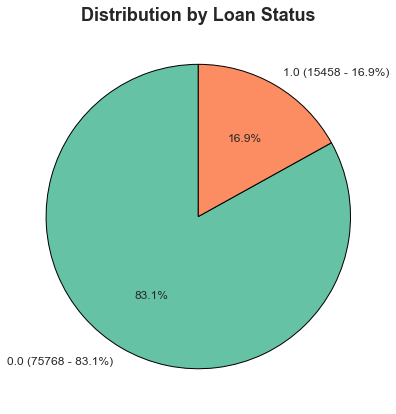

In [66]:
# Calculating the number of samples per each loan status
values_by_status = df_total_origin['loan_status'].value_counts()

# Setting a color palette to ensure distinct color differentiation
custom_colors = sns.color_palette("Set2", n_colors=len(values_by_status))

# Increasing the overall font size for better readability
plt.rc('font', size=14)

# Creating an pie chart
fig, ax = plt.subplots(figsize=(7, 7))
ax.pie(
    values_by_status,
    labels=[f"{label} ({count} - {pct:.1f}%)" for label, count, pct in 
            zip(values_by_status.index, values_by_status, values_by_status / values_by_status.sum() * 100)],
    colors=custom_colors,
    autopct='%1.1f%%',
    startangle=90,
    wedgeprops={'edgecolor': 'black', 'linewidth': 1},
    textprops={'fontsize': 12}
)

# Setting a title
ax.set_title('Distribution by Loan Status', fontsize=18, fontweight='bold')
plt.ylabel('')  # Removing y-label as it's unnecessary in a pie chart

# Displaying the pie chart
plt.show()

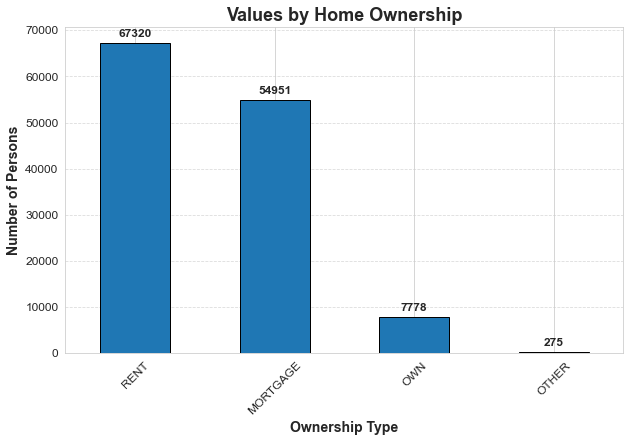

In [67]:
# Calculating the number of samples per each ownership type
values_by_ownership = df_total_origin['person_home_ownership'].value_counts()

# Setting up a larger figure size and a color palette
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting a bar chart with custom colors
values_by_ownership.plot(kind='bar', ax=ax, edgecolor='black')

# Adding a title
plt.title('Values by Home Ownership', fontsize=18, fontweight='bold')

# Labeling x and y axes with consistent font size
plt.xlabel('Ownership Type', fontsize=14, fontweight='bold')
plt.ylabel('Number of Persons', fontsize=14, fontweight='bold')

# Customizing ticks
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Adding gridlines for easier value comparison
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

# Annotating each bar with the count value
for index, value in enumerate(values_by_ownership):
    ax.text(index, value + max(values_by_ownership) * 0.02, f"{value}", ha='center', fontsize=12, fontweight='bold')

# Displaying the chart
plt.show()

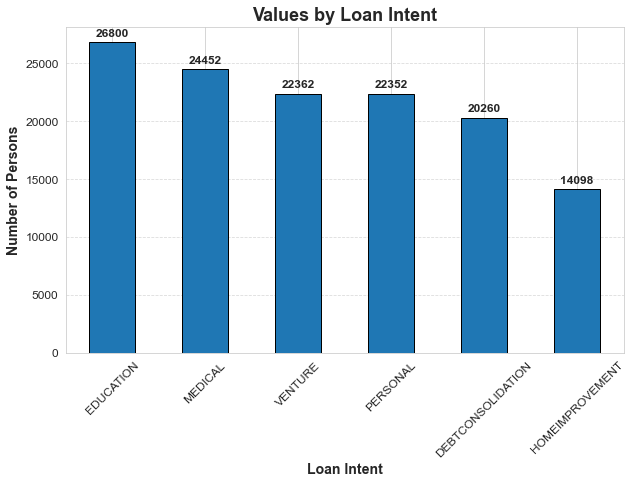

In [68]:
# Calculating the number of samples per each loan_intent
values_by_intent = df_total_origin['loan_intent'].value_counts()

# Setting up a larger figure size and a color palette
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting a bar chart with custom colors
values_by_intent.plot(kind='bar', ax=ax, edgecolor='black')

# Adding a title
plt.title('Values by Loan Intent', fontsize=18, fontweight='bold')

# Labeling x and y axes with consistent font size
plt.xlabel('Loan Intent', fontsize=14, fontweight='bold')
plt.ylabel('Number of Persons', fontsize=14, fontweight='bold')

# Customizing ticks
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Adding gridlines for easier value comparison
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

# Annotating each bar with the count value
for index, value in enumerate(values_by_intent):
    ax.text(index, value + max(values_by_intent) * 0.02, f"{value}", ha='center', fontsize=12, fontweight='bold')

# Displaying the chart
plt.show()

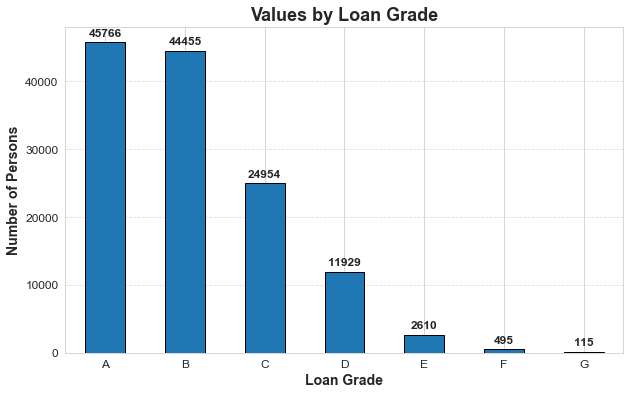

In [72]:
# Calculating the number of samples per each loan_grade
values_by_grade = df_total_origin['loan_grade'].value_counts()

# Setting up a larger figure size and a color palette
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting a bar chart with custom colors
values_by_grade.plot(kind='bar', ax=ax, edgecolor='black')

# Adding a title
plt.title('Values by Loan Grade', fontsize=18, fontweight='bold')

# Labeling x and y axes with consistent font size
plt.xlabel('Loan Grade', fontsize=14, fontweight='bold')
plt.ylabel('Number of Persons', fontsize=14, fontweight='bold')

# Customizing ticks
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)

# Adding gridlines for easier value comparison
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

# Annotating each bar with the count value
for index, value in enumerate(values_by_grade):
    ax.text(index, value + max(values_by_grade) * 0.02, f"{value}", ha='center', fontsize=12, fontweight='bold')

# Displaying the chart
plt.show()

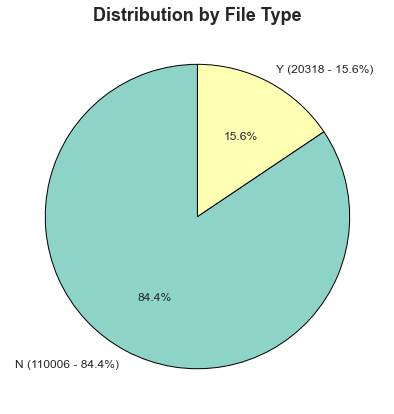

In [73]:
# Calculating the number of samples per each file type
values_by_file = df_total_origin['cb_person_default_on_file'].value_counts()

# Setting a color palette to ensure distinct color differentiation
custom_colors = sns.color_palette("Set3", n_colors=len(values_by_file))

# Increasing the overall font size for better readability
plt.rc('font', size=14)

# Creating an pie chart
fig, ax = plt.subplots(figsize=(7, 7))
ax.pie(
    values_by_file,
    labels=[f"{label} ({count} - {pct:.1f}%)" for label, count, pct in 
            zip(values_by_file.index, values_by_file, values_by_file / values_by_file.sum() * 100)],
    colors=custom_colors,
    autopct='%1.1f%%',
    startangle=90,
    wedgeprops={'edgecolor': 'black', 'linewidth': 1},
    textprops={'fontsize': 12}
)

# Setting a title
ax.set_title('Distribution by File Type', fontsize=18, fontweight='bold')
plt.ylabel('')  # Removing y-label as it's unnecessary in a pie chart

# Displaying the pie chart
plt.show()

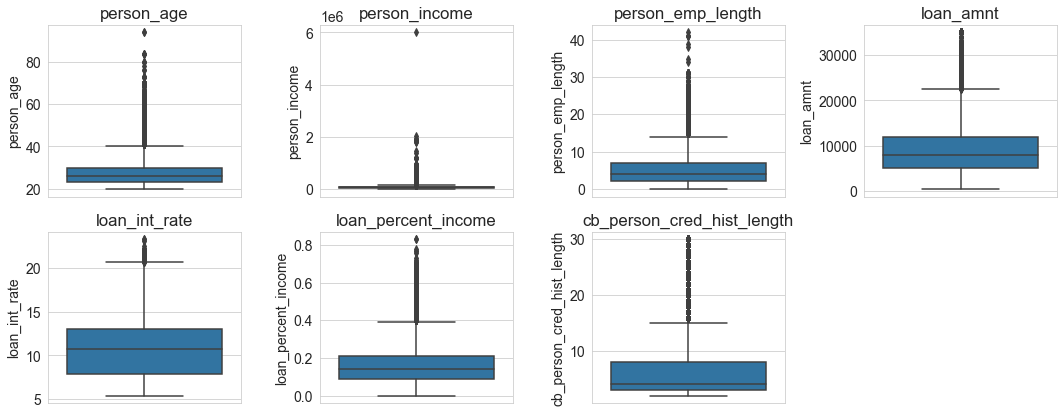

In [74]:
# Plotting the range distribution of each column (boxplots)

num_columns = ['person_age','person_income', 
               'person_emp_length', 
               'loan_amnt',
               'loan_int_rate', 
               'loan_percent_income',
               'cb_person_cred_hist_length']

plt.figure(figsize=(15, 6))

for i, column in enumerate(df_total_origin[num_columns], start=1):
    plt.subplot(2, 4, i)
    sns.boxplot(y=df_total_origin[column])
    plt.title(column)

plt.tight_layout()
plt.show();

## Feature Engineering

In [75]:
def feature_engineering(df):
    
    # Interaction Features
    df['loan_income_ratio'] = df['loan_amnt'] / df['person_income']
    df['income_rate_product'] = df['loan_percent_income'] * df['loan_int_rate']
    df['person_age_to_person_income'] = (df['person_age'] / df['person_income'])
    #df['person_emp_length_to_person_age'] = (df['person_emp_length'] / df['person_age'])
    
    #Binning Features
    age_bins = [25, 30, 35, 40, 50, 60, 120]
    age_labels = ['<25', '25-30', '30-35', '40-50', '50-60', '60+']
    df['age_bin'] = pd.cut(df['person_age'], bins=age_bins, labels=age_labels)

    income_bins = [4000, 10000, 40000, 60000, 80000, 200000, np.inf]
    income_labels = ['Low', 'Medium-Low', 'Medium', 'Medium-High', 'High', 'Very-High']
    df['income_bin'] = pd.cut(df['person_income'], bins=income_bins, labels=income_labels)

    #Polynomial Features
    df['income_squared'] = df['person_income'] ** 2

    return df

In [76]:
cat_cols = ['person_home_ownership',
      'loan_intent', 'loan_grade', 'cb_person_default_on_file','age_bin', 'income_bin']

In [77]:
def factorize(df):
    
    df['person_home_ownership'] = pd.factorize(df['person_home_ownership'])[0]
    df['loan_intent'] = pd.factorize(df['loan_intent'])[0]
    df['loan_grade'] = pd.factorize(df['loan_grade'])[0]
    df['cb_person_default_on_file'] = pd.factorize(df['cb_person_default_on_file'])[0]
    
    df['age_bin'] = pd.factorize(df['age_bin'])[0]
    df['income_bin'] = pd.factorize(df['income_bin'])[0]
    
    return df

In [78]:
# Feature Engineering & factorizeing categorical features
df_total_factorize = feature_engineering(df_total_origin)
df_total_factorize = factorize(df_total_origin)

In [79]:
# Defineing categorical columns as 'Category' type

def categorize(df, columns):
    
    for col in columns:
        df[col] = df[col].astype(str).astype('category')
        
    return df

In [80]:
# Defineing categorical columns as 'Category' type
df_total_factorize = categorize(df_total_factorize, cat_cols)

In [81]:
# Spliting Train & Test Sets

train_factorized = df_total_factorize.loc[df_total_factorize['loan_status'].isnull() != True].copy()
train_factorized.drop('id',axis=1, inplace = True)

test_factorized = df_total_factorize.loc[df_total_factorize['loan_status'].isnull() == True].copy()
test_ids = test_factorized['id']
test_factorized.drop(['id','loan_status'], axis = 1, inplace = True)

train_factorized.shape, test_factorized.shape

((91226, 18), (39098, 17))

In [82]:
# Droping duplicate values fro train set (if any)

train_factorized.drop_duplicates(inplace=True)
train_factorized.shape

(91060, 18)

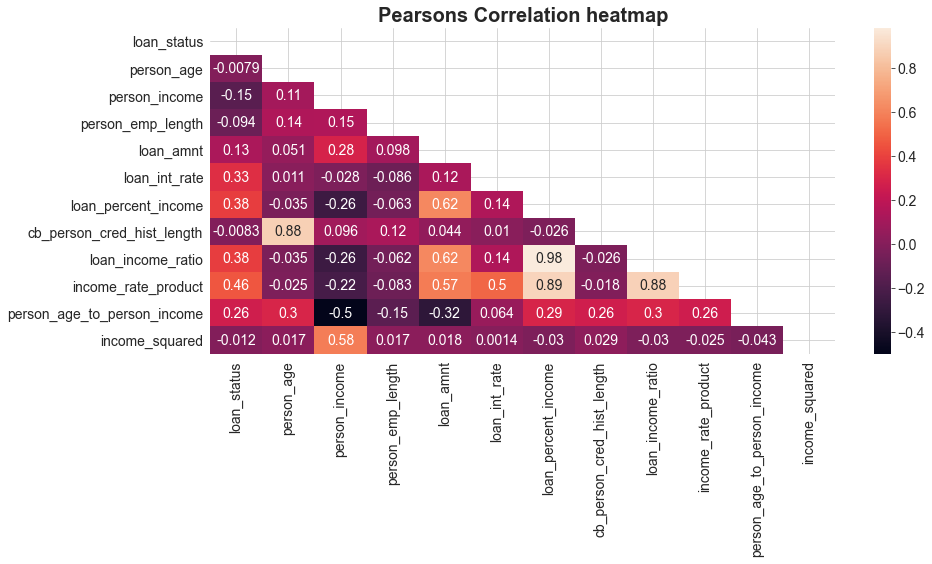

In [84]:
# Pearsons Correlation Heatmap
df_corr = train_factorized[['loan_status', 'person_age', 'person_income',
       'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 
       'cb_person_cred_hist_length',  'loan_income_ratio',
       'income_rate_product', 
       'person_age_to_person_income',
#        'person_emp_length_to_person_age', 
       'income_squared'
                ]].corr()

fig, ax = plt.subplots(figsize=(14,6))

sns.heatmap(data=df_corr,
           annot=True, 
        mask = np.triu(np.ones_like(df_corr, dtype=bool)),)

plt.title('Pearsons Correlation heatmap', fontweight='bold', fontsize = 20)

plt.show()

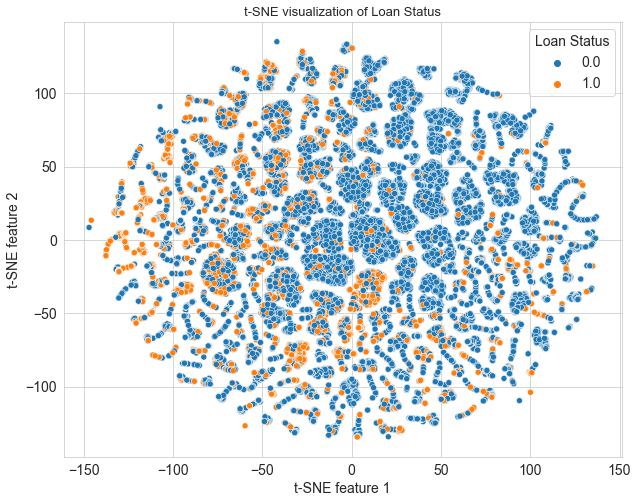

Wall time: 24min 49s


In [42]:
%%time

# Copying the df that will be used for plotting
train_df_plot = train_factorized.copy()

# Separating features and labels
X_plot = train_df_plot[['person_age', 'person_income', 'person_home_ownership',
       'loan_percent_income', 'cb_person_default_on_file',
       'cb_person_cred_hist_length', 'loan_status', 'loan_income_ratio',
       'income_rate_product', 'person_age_to_person_income', 'age_bin',
       'income_bin', 'income_squared',
          'person_emp_length', 'loan_intent', #'loan_grade', #'loan_amnt',
       #'loan_int_rate'              
                       ]].copy()

y_plot = train_df_plot['loan_status']

# Performing t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=40)
X_tsne = tsne.fit_transform(X_plot)

# Creating a scatter plot
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_plot, legend='full')
plt.title('t-SNE visualization of Loan Status', fontsize = 13)
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.legend(title='Loan Status')
plt.show()

## Defineing Features & Target

In [85]:
# Defining independed and depended variables and Selecting the features (For factorized categories)

X_f = train_factorized.drop('loan_status', axis=1)

y_f = train_factorized['loan_status']

X_f.shape, y_f.shape

((91060, 17), (91060,))

## Models

### Light GBM1

For all the models OPTUNA Optimizer is used for hyperparameters tunning

In [36]:
# # Define the objective function for Optuna optimization
# def objective(trial, X, Y):
#     """
#     This function optimizes hyperparameters for LightGBM using stratified K-fold cross-validation and Optuna.
#     """
#     # Define the hyperparameter search space
#     param = {
#         "objective": "binary",
#         "metric": "auc",
#         "verbosity": -1,
#         "boosting_type": "gbdt",
#         "random_state": 42,
        
#         "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.023),
#         "n_estimators": trial.suggest_int("n_estimators", 1600, 3000),
#         "lambda_l1": trial.suggest_float("lambda_l1", 0.01, 0.045),
#         "lambda_l2": trial.suggest_float("lambda_l2", 0.3, 0.55),
#         "max_depth": trial.suggest_int("max_depth", 4, 9),
#         "num_leaves": trial.suggest_int("num_leaves", 18, 55),
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.22, 0.55),
#         "subsample": trial.suggest_float("subsample", 0.85, 1.0),
#         "min_child_samples": trial.suggest_int("min_child_samples", 40, 85),
#     }

#     # Initialize the stratified K-fold cross-validator
#     skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#     auc_scores = []

#     # Perform stratified K-fold cross-validation
#     for train_index, val_index in skf.split(X, Y):
#         X_train, X_val = X.iloc[train_index], X.iloc[val_index]
#         y_train, y_val = Y.iloc[train_index], Y.iloc[val_index]
        
#         # Create and fit the classifier
#         lgbm_classifier = LGBMClassifier(**param)
#         lgbm_classifier.fit(X_train, y_train)

#         # Predict probabilities for validation data
#         y_pred_lgb = lgbm_classifier.predict_proba(X_val)[:, 1]
#         auc = roc_auc_score(y_val, y_pred_lgb)
#         auc_scores.append(auc)

#     # Return the mean AUC score across all folds
#     mean_auc = np.mean(auc_scores)
#     return mean_auc

# # Setup Optuna study with a sampler
# sampler = optuna.samplers.TPESampler(seed=42)
# study = optuna.create_study(direction="maximize", sampler=sampler)

# # Run the optimization
# study.optimize(lambda trial: objective(trial, X_f, y_f), n_trials=100)

# # Output the best parameters and score
# best_params_lgb1 = study.best_params
# best_score_lgb1 = study.best_value

# print("Best score:", best_score_lgb1)
# print("Best parameters:", best_params_lgb1)

In [86]:
best_params_lgb =  {
    
        "objective": "binary",
        "metric": "auc",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "random_state": 42,
    
 'learning_rate': 0.02158738196752842,
 'n_estimators': 2330,
 'lambda_l1': 0.012359780389166875,
 'lambda_l2': 0.32908310193790913,
 'max_depth': 7,
 'num_leaves': 42,
 'colsample_bytree': 0.43277812653765485,
 'subsample': 0.9227234421267624,
 'min_child_samples': 41
            }

In [87]:
# Creating dictionaries for of fold & test predictions

oof_preds_dict = {}
test_preds_dict = {}

In [88]:
# Defineing LGBMClassifier1
lgbm_classifier1 = LGBMClassifier(**best_params_lgb)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores1 = []
predictions_lgb1 = [] # To store test(unseen) predictions
y_val_all = []  # To store all y_val for confusion matrix
y_pred_all = []  # To store all val predictions for confusion matrix
y_pred_prob_all = []  # To store predicted probabilities for ROC curve

# Initialize the OOF array to store the predictions
oof_preds = np.zeros(X_f.shape[0])
test_preds = np.zeros(test_factorized.shape[0])

for train_index, val_index in skf.split(X_f, y_f):
    X_train, X_val = X_f.iloc[train_index], X_f.iloc[val_index]
    y_train, y_val = y_f.iloc[train_index], y_f.iloc[val_index]
    
    # Fit the regressor on the training data
    lgbm_classifier1.fit(X_train, y_train)

    # Evaluate the regressor on the test data
    y_pred_lgb = lgbm_classifier1.predict_proba(X_val)[:, 1]
    y_pred_val = lgbm_classifier1.predict(X_val) 
    
    auc = roc_auc_score(y_val, y_pred_lgb)
    scores1.append(auc)
    
    print('The Score for fold:', auc)
    
    # Printing the upcoming data
    y_pred = lgbm_classifier1.predict_proba(test_factorized)[:, 1]
    predictions_lgb1.append(y_pred)
    
    # Predictions on val sets
    oof_preds[val_index] = y_pred_lgb
    y_val_all.extend(y_val)
    y_pred_all.extend(y_pred_val)
    y_pred_prob_all.extend(y_pred_lgb)

test_preds = np.mean(predictions_lgb1,axis=0)   
print('Total Score: ', np.mean(scores1))

The Score for fold: 0.9578933785241763
The Score for fold: 0.9578788363346594
The Score for fold: 0.9583358313931258
The Score for fold: 0.9638501770510585
The Score for fold: 0.9615296365245919
Total Score:  0.9598975719655224


In [89]:
# Saveing of fold & test predictions in dict
oof_preds_dict["lgb1"] = oof_preds
test_preds_dict["lgb1"] = test_preds

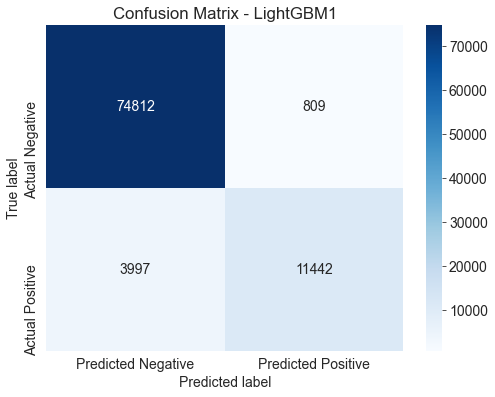

In [90]:
# Plotting the confusion matrix for LightGBM1

conf_matrix = confusion_matrix(y_val_all, y_pred_all)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix - LightGBM1')
plt.show()

### LightGBM 2

In [91]:
# Calculating the Class Weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_f), y=y_f)
class_weights = dict(enumerate(class_weights))

sample_pos_weight = class_weights[1]/class_weights[0]

In [92]:
best_params_lgb_2 =  { 
 "objective": "binary",
 "metric": "auc",
 "verbosity": -1,
 "boosting_type": "gbdt",
 "random_state": 42,
 'early_stopping_round': 200,
 'sample_pos_weight': sample_pos_weight,       
 'learning_rate': 0.01211807158054302,
 'n_estimators': 4571,
 'reg_lambda': 1.1257262554496439,
 'max_depth': 16,
 'num_leaves': 62,
 'colsample_bytree': 0.41470994536225786,
 'subsample': 0.9208787084053739,
 'min_child_samples': 23,
 'max_bin': 14377,
 'min_child_weight': 0.5614141452395832,
 'subsample_freq': 5
            }

In [93]:
# Defineing LGBMClassifier
lgbm_classifier2 = LGBMClassifier(**best_params_lgb_2)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = []
predictions_lgb = []
y_val_all2 = []  # To store all y_val for confusion matrix
y_pred_all2 = []  # To store all y_pred for confusion matrix
y_pred_prob_all2 = []  # To store predicted probabilities for ROC curve

# Initialize the OOF array to store the predictions
oof_preds2 = np.zeros(X_f.shape[0])
test_preds2 = np.zeros(test_factorized.shape[0])

for train_index, val_index in skf.split(X_f, y_f):
    X_train, X_val = X_f.iloc[train_index], X_f.iloc[val_index]
    y_train, y_val = y_f.iloc[train_index], y_f.iloc[val_index]
    
    # Fit the regressor on the training data
    lgbm_classifier2.fit(X_train, y_train,
                       eval_set = [(X_val, y_val)],
                       callbacks = [log_evaluation(0),
                        early_stopping(200, verbose = False)]
                                    )

    # Evaluate the regressor on the test data
    y_pred_lgb = lgbm_classifier2.predict_proba(X_val)[:, 1]
    y_pred_val = lgbm_classifier2.predict(X_val) 
    
    auc = roc_auc_score(y_val, y_pred_lgb)
    scores.append(auc)
    
    print('The Score for fold:', auc)
    
    # Predicting the upcoming data
    y_pred = lgbm_classifier2.predict_proba(test_factorized)[:, 1]
    predictions_lgb.append(y_pred)
    
    # Predictions on val sets
    oof_preds2[val_index] = y_pred_lgb
    y_val_all2.extend(y_val)
    y_pred_all2.extend(y_pred_val)
    y_pred_prob_all2.extend(y_pred_lgb)

test_preds2 = np.mean(predictions_lgb, axis=0)    
    
print('Total Score: ', np.mean(scores))

The Score for fold: 0.9594706246134819
The Score for fold: 0.9612971670802882
The Score for fold: 0.9617990843911403
The Score for fold: 0.9663564447544513
The Score for fold: 0.963148079503051
Total Score:  0.9624142800684826


In [94]:
# Saveing of fold & test predictions in dict
oof_preds_dict["lgb2"] = oof_preds2
test_preds_dict["lgb2"] = test_preds2

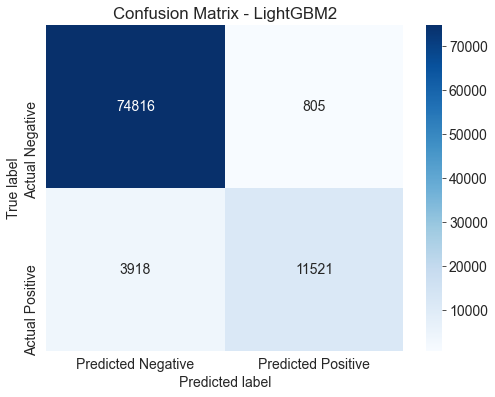

In [95]:
# Now plot the confusion matrix
conf_matrix2 = confusion_matrix(y_val_all2, y_pred_all2)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix2, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix - LightGBM2')
plt.show()

### LightGBM 3

In [96]:
name = 'LGB3'
params_lgb3 = {
    'objective': 'binary',
    'metric': 'auc',
    'max_depth': -1,
    'verbosity': -1,
    'n_estimators': 3000,
    'max_bin': 1024,
    'boosting_type': 'gbdt',
    'colsample_bytree': 0.57,        
    'eta': 0.055,
    'reg_lambda': 10.8,
    'min_child_samples': 70,
    'early_stopping_rounds': 300,
    #'sample_pos_weight': sample_pos_weight,
}

In [97]:
# Define LGBMClassifier
lgbm_classifier3 = LGBMClassifier(**params_lgb3)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores3 = []
predictions_lgb3 = []
y_val_all3 = []  # To store all y_val for confusion matrix
y_pred_all3 = []  # To store all y_pred for confusion matrix
y_pred_prob_all3 = []  # To store predicted probabilities for ROC curve

# Initialize the OOF array to store the predictions
oof_preds3 = np.zeros(X_f.shape[0])
test_preds3 = np.zeros(test_factorized.shape[0])

for train_index, val_index in skf.split(X_f, y_f):
    X_train, X_val = X_f.iloc[train_index], X_f.iloc[val_index]
    y_train, y_val = y_f.iloc[train_index], y_f.iloc[val_index]
    
    # Fit the regressor on the training data
    lgbm_classifier3.fit(X_train, y_train,
                       eval_set = [(X_val, y_val)],
                       callbacks = [log_evaluation(0),
                        early_stopping(200, verbose = False)]
                                    )

    # Evaluate the regressor on the test data
    y_pred_lgb3 = lgbm_classifier3.predict_proba(X_val)[:, 1]
    y_pred_val3 = lgbm_classifier3.predict(X_val) 
    
    auc = roc_auc_score(y_val, y_pred_lgb3)
    scores3.append(auc)
    
    print('The Score for fold:', auc)
    
    # Predicting the upcoming data
    y_pred3 = lgbm_classifier3.predict_proba(test_factorized)[:, 1]
    predictions_lgb3.append(y_pred3)
    
    # Predictions on val sets
    oof_preds3[val_index] = y_pred_lgb3
    y_val_all3.extend(y_val)
    y_pred_all3.extend(y_pred_val3)
    y_pred_prob_all3.extend(y_pred_lgb3)

test_preds3 = np.mean(predictions_lgb3, axis=0)    
    
print('Total Score: ', np.mean(scores3))

The Score for fold: 0.9582051525057089
The Score for fold: 0.95914137002849
The Score for fold: 0.9592998612163628
The Score for fold: 0.9648079545874999
The Score for fold: 0.9613766482055766
Total Score:  0.9605661973087276


In [98]:
# Saveing of fold & test predictions in dict
oof_preds_dict["lgb3"] = oof_preds3
test_preds_dict["lgb3"] = test_preds3

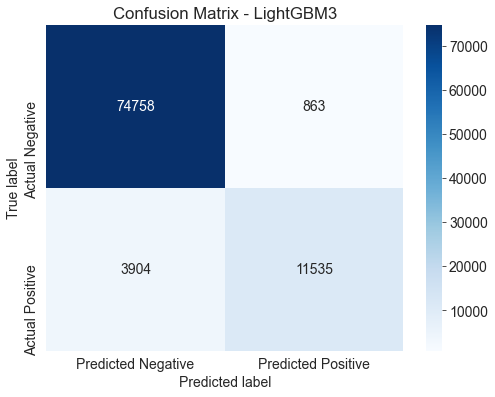

In [99]:
# Now plot the confusion matrix
conf_matrix3 = confusion_matrix(y_val_all3, y_pred_all3)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix3, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix - LightGBM3')
plt.show()

### Catboost 1

In [100]:
params_cat = {
            'task_type'           : "CPU",
            'loss_function'       : 'Logloss',
            'eval_metric'         : "AUC",
            'bagging_temperature' : 0.25,
            'colsample_bylevel'   : 0.40,
            'iterations'          : 5000,
            'learning_rate'       : 0.045,
            'max_depth'           : 7,
            'l2_leaf_reg'         : 0.80,
            'min_data_in_leaf'    : 30,
            'random_strength'     : 0.25,
            'random_state'        : 42,
            'early_stopping_rounds': 200,
            'use_best_model'       : True,
            'verbose':False
}

In [101]:
# Define LGBMClassifier
cat_classifier1 = CatBoostClassifier(**params_cat)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores4 = []
predictions_lgb4 = []
y_val_all4 = []  # To store all y_val for confusion matrix
y_pred_all4 = []  # To store all y_pred for confusion matrix
y_pred_prob_all4 = []  # To store predicted probabilities for ROC curve

# Initialize the OOF array to store the predictions
oof_preds4 = np.zeros(X_f.shape[0])
test_preds4 = np.zeros(test_factorized.shape[0])

for train_index, val_index in skf.split(X_f, y_f):
    X_train, X_val = X_f.iloc[train_index], X_f.iloc[val_index]
    y_train, y_val = y_f.iloc[train_index], y_f.iloc[val_index]
    
    # Fit the regressor on the training data
    cat_classifier1.fit(X_train, y_train,
                       eval_set = [(X_val, y_val)],
                        cat_features=cat_cols
                      
                                    )

    # Evaluate the regressor on the test data
    y_pred_lgb4 = cat_classifier1.predict_proba(X_val)[:, 1]
    y_pred_val4 = cat_classifier1.predict(X_val) 
    
    auc = roc_auc_score(y_val, y_pred_lgb4)
    scores4.append(auc)
    
    print('The Score for fold:', auc)
    
    # Predicting the upcoming data
    y_pred4 = cat_classifier1.predict_proba(test_factorized)[:, 1]
    predictions_lgb4.append(y_pred4)
    
    # Predictions on val sets
    oof_preds4[val_index] = y_pred_lgb4
    y_val_all4.extend(y_val)
    y_pred_all4.extend(y_pred_val4)
    y_pred_prob_all4.extend(y_pred_lgb4)

test_preds4 = np.mean(predictions_lgb4, axis=0)    
    
print('Total Score: ', np.mean(scores4))

The Score for fold: 0.9550902397952491
The Score for fold: 0.9553193385457421
The Score for fold: 0.9577626551423604
The Score for fold: 0.9632739388927184
The Score for fold: 0.9592243841240564
Total Score:  0.9581341113000252


In [102]:
# Saveing of fold & test predictions in dict
oof_preds_dict["cat"] = oof_preds4
test_preds_dict["cat"] = test_preds4

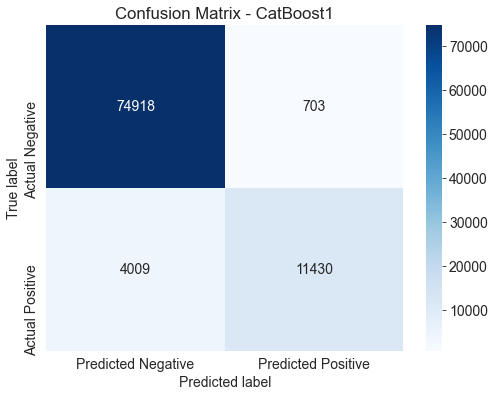

In [103]:
# Now plot the confusion matrix
conf_matrix4 = confusion_matrix(y_val_all4, y_pred_all4)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix4, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix - CatBoost1')
plt.show()

### CatBoost 2

In [104]:
name = 'CAT2'
params_cat2 = {
    'iterations': 3000,
    'depth': 7,
    'eta': 0.3, 
    'reg_lambda': 40.0, 
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'random_state': 42,
    'min_data_in_leaf': 51,
    'early_stopping_rounds': 300,
    'verbose':False,
    'use_best_model': True,
}

In [105]:
# Define LGBMClassifier
cat_classifier2 = CatBoostClassifier(**params_cat2)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores5 = []
predictions_lgb5 = []
y_val_all5 = []  # To store all y_val for confusion matrix
y_pred_all5 = []  # To store all y_pred for confusion matrix
y_pred_prob_all5 = []  # To store predicted probabilities for ROC curve

# Initialize the OOF array to store the predictions
oof_preds5 = np.zeros(X_f.shape[0])
test_preds5 = np.zeros(test_factorized.shape[0])

for train_index, val_index in skf.split(X_f, y_f):
    X_train, X_val = X_f.iloc[train_index], X_f.iloc[val_index]
    y_train, y_val = y_f.iloc[train_index], y_f.iloc[val_index]
    
    # Fit the regressor on the training data
    cat_classifier2.fit(X_train, y_train,
                       eval_set = [(X_val, y_val)],
                        cat_features=cat_cols
                      
                                    )

    # Evaluate the regressor on the test data
    y_pred_lgb5 = cat_classifier2.predict_proba(X_val)[:, 1]
    y_pred_val5 = cat_classifier2.predict(X_val) 
    
    auc = roc_auc_score(y_val, y_pred_lgb5)
    scores5.append(auc)
    
    print('The Score for fold:', auc)
    
    # Predicting the upcoming data
    y_pred5 = cat_classifier2.predict_proba(test_factorized)[:, 1]
    predictions_lgb5.append(y_pred5)
    
    # Predictions on val sets
    oof_preds5[val_index] = y_pred_lgb5
    y_val_all5.extend(y_val)
    y_pred_all5.extend(y_pred_val5)
    y_pred_prob_all5.extend(y_pred_lgb5)

test_preds5 = np.mean(predictions_lgb5, axis=0)    
    
print('Total Score: ', np.mean(scores5))

The Score for fold: 0.9542593279736137
The Score for fold: 0.9540214323252477
The Score for fold: 0.9571323732447348
The Score for fold: 0.9613033337193192
The Score for fold: 0.9578378110555504
Total Score:  0.9569108556636932


In [106]:
# Saveing of fold & test predictions in dict
oof_preds_dict["cat2"] = oof_preds5
test_preds_dict["cat2"] = test_preds5

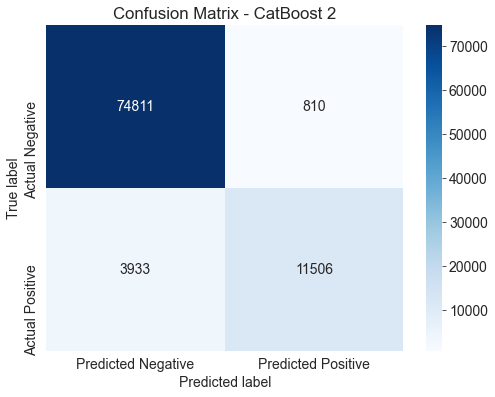

In [107]:
# Now plot the confusion matrix
conf_matrix5 = confusion_matrix(y_val_all5, y_pred_all5)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix5, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix - CatBoost 2')
plt.show()

### HillClimbing

Hill-climbing algorithm is a heuristic optimization method often used in artificial intelligence, machine learning, and operations research. <br>
The hill-climbing algorithm is an iterative algorithm that starts with an arbitrary solution and tries to find a better solution by incrementally adjusting the current one. It's often used for problems where finding the absolute best solution is computationally difficult.

In [110]:
# !pip install hillclimbers

In [108]:
from hillclimbers import climb_hill, partial

   /\  
  /__\  hillclimbers 
 /    \
/______\ 

Models to be ensembled | (5 total): 

lgb2: 0.96236 (best solo model)
lgb3: 0.96051
lgb1: 0.95988
cat:  0.95809
cat2: 0.95688

[Data preparation completed successfully] - [Initiate hill climbing] 

Iteration: 1 | Model added: cat | Best weight: 0.197 | Best roc_auc_score: 0.96263
Iteration: 2 | Model added: cat2 | Best weight: 0.060 | Best roc_auc_score: 0.96266
Iteration: 3 | Model added: lgb3 | Best weight: 0.037 | Best roc_auc_score: 0.96267
Iteration: 4 | Model added: lgb1 | Best weight: -0.002 | Best roc_auc_score: 0.96267


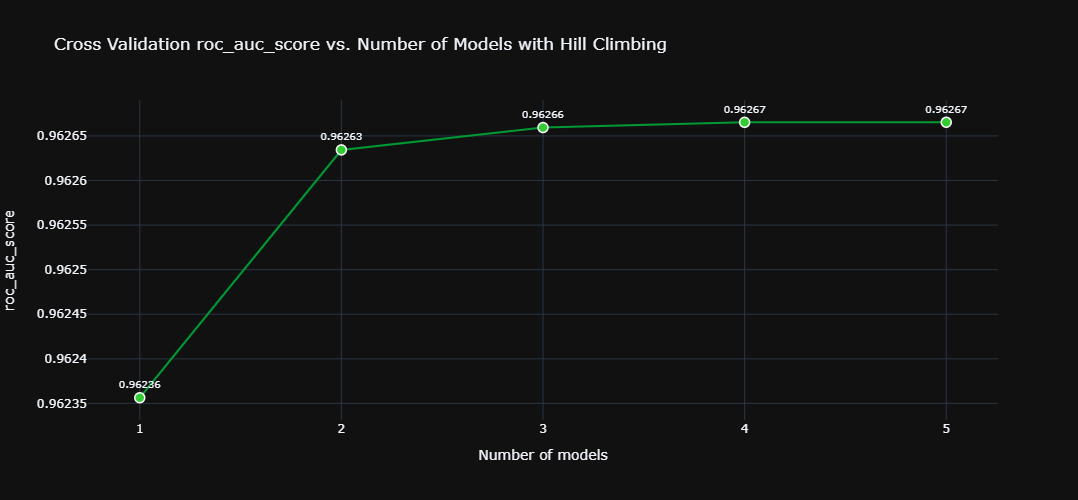

Wall time: 5min 50s


In [109]:
%%time

hill_climb_test_preds, _ = climb_hill(
    train=train_factorized,
    oof_pred_df=pd.DataFrame(oof_preds_dict),
    test_pred_df=pd.DataFrame(test_preds_dict),
    target="loan_status",
    objective="maximize",
    eval_metric=partial(roc_auc_score),
    negative_weights=True,
    precision=0.001,
    plot_hill=True,
    plot_hist=False,
    return_oof_preds=True)

### Autogulon

In [ ]:
# Continue in home to run the code

In [111]:
from autogluon.tabular import TabularPredictor

ModuleNotFoundError: No module named 'autogluon'

In [ ]:
predictor = TabularPredictor(label='loan_status',
                             eval_metric='roc_auc',
                             problem_type='binary',
                             groups='fold'
                             ).fit(train_data=train_factorized,
                                   presets='best_quality',
                                   time_limit=3600*2, #3600*2
                                   verbosity=2,
                                   num_cpus=3,  # 4
                                   # num_gpus=2,
                                   excluded_model_types=['KNN', 'NN', 'XT', 'FASTAI', 'NN_TORCH'],
                                   save_bag_folds=True,    # Retains all fold models for stacked ensembles
                                    keep_only_best=False    # Keeps all models, not just the best ones
                                   ,fit_weighted_ensemble=True
                                  )

## Predictions

In [114]:
# Making a new dataframe called Submission
submission_hills = pd.DataFrame({
    "id": test_ids,
    "loan_status": hill_climb_test_preds
})

In [118]:
submission_hills.to_csv('..\Predictions\submission_hills.csv', index=False)